<a href="https://colab.research.google.com/github/bacnc1/Medical-Image-Analysis/blob/main/Pneumonia_preproced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle


In [2]:
from google.colab import files
files.upload()  # Use this to upload your kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bacnc1","key":"99ff765174b2dadd13b36e0eb17024ef"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json




In [4]:
!kaggle datasets list


ref                                                          title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
valakhorasani/mobile-device-usage-and-user-behavior-dataset  Mobile Device Usage and User Behavior Dataset   11KB  2024-09-28 20:21:12          10453        193  1.0              
lainguyn123/student-performance-factors                      Student Performance Factors                     94KB  2024-09-02 10:53:57          39153        678  1.0              
valakhorasani/gym-members-exercise-dataset                   Gym Members Exercise Dataset                    22KB  2024-10-06 11:27:38           5306         95  1.0              
jaseemck/paralympics-2024                                    Paralympics 2024                       

In [5]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge

100% 3.66G/3.66G [03:06<00:00, 22.3MB/s]
100% 3.66G/3.66G [03:06<00:00, 21.0MB/s]


In [6]:
!unzip /content/rsna-pneumonia-detection-challenge.zip



Streaming output truncated to the last 5000 lines.
  inflating: stage_2_train_images/d5231546-354e-4071-9af1-6644beabfd86.dcm  
  inflating: stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: stage_2_train_images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: stage_2_train_images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: stage_2_train_images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: stage_2_train_images/d52ce67b-be7c-4349-8dc4-38562928d208.dcm  
  inflating: stage_2_train_images/d535a3c8-c4a4-4856-b5cd-17f6332eac8b.dcm  
  inflating: stage_2_train_images/d5360dc4-6bea-4a7b-bc49-5b2547ad7877.dcm  
  inflating: stage_2_train_images/d5364bc1-bc2a-4bd0-a1bd-0cfb5a369ccc.dcm  
  inflating: stage_2_trai

In [7]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 59.5 MB/s eta 0:00:00


In [8]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [9]:
labels = pd.read_csv('/content/stage_2_train_labels.csv')

In [10]:
labels.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [11]:
labels = labels.drop_duplicates(subset="patientId")


In [12]:
ROOT_PATH = Path("/content/stage_2_train_images")
SAVE_PATH = Path("Processed")

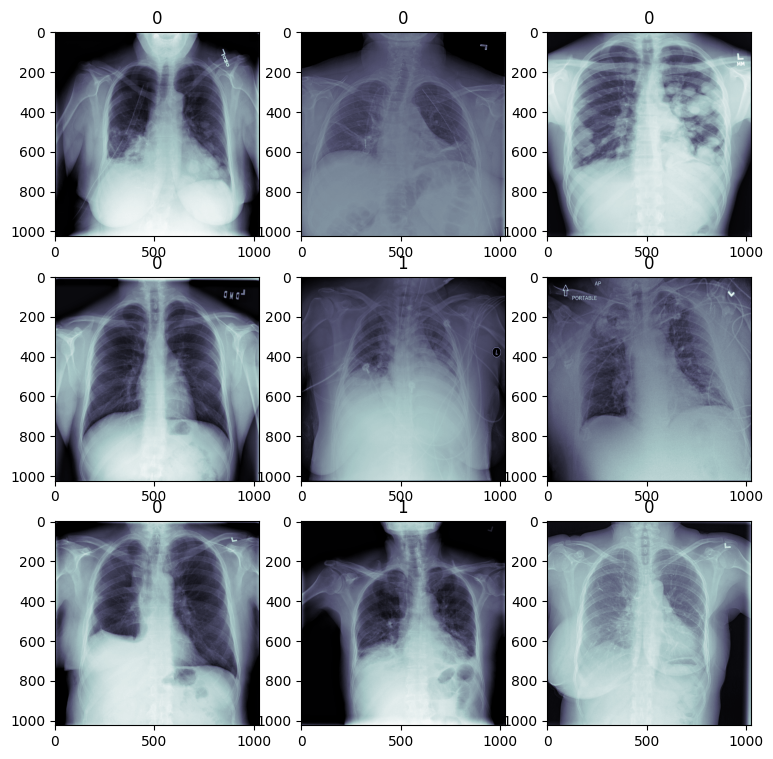

In [13]:
fig, axis = plt.subplots(3,3, figsize=(9,9))
c = 0
for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.dcmread(dcm_path).pixel_array
        label = labels["Target"].iloc[c]
        axis[i][j].imshow(dcm, cmap="bone")
        axis[i][j].set_title(label)
        c+=1



In [14]:
sums = 0
sums_squared = 0

for c, patient_id in enumerate(tqdm(labels.patientId)):
    dcm_path = ROOT_PATH/patient_id  # Create the path to the dcm file
    dcm_path = dcm_path.with_suffix(".dcm")  # And add the .dcm suffix

    # Read the dicom file with pydicom and standardize the array
    dcm = pydicom.dcmread(dcm_path).pixel_array / 255

    # Resize the image as 1024x1024 is way to large to be handeled by Deep Learning models at the moment
    # Let's use a shape of 224x224
    # In order to use less space when storing the image we convert it to float16
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)

    # Retrieve the corresponding label
    label = labels.Target.iloc[c]

    # 4/5 train split, 1/5 val split
    train_or_val = "train" if c < 24000 else "val"

    current_save_path = SAVE_PATH/train_or_val/str(label) # Define save path and create if necessary
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/patient_id, dcm_array)  # Save the array in the corresponding directory

    normalizer = dcm_array.shape[0] * dcm_array.shape[1]  # Normalize sum of image
    if train_or_val == "train":  # Only use train data to compute dataset statistics
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (np.power(dcm_array, 2).sum()) / normalizer


  0%|          | 0/26684 [00:00<?, ?it/s]

In [15]:
mean = sums / 24000
std = np.sqrt(sums_squared / 24000 - (mean**2))

In [16]:
print(f"Mean of Dataset: {mean}, STD: {std}")

Mean of Dataset: 0.4903962485384803, STD: 0.24795070634161256


In [17]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 29.6 MB/s eta 0:00:00


In [18]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 34.1 MB/s eta 0:00:00


In [19]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [20]:
def load_file(path):
  return np.load(path).astype(np.float32)


In [21]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248),
    transforms.RandomAffine(degrees=(-5, 5), translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.49], [0.248]),
])

In [22]:
train_dataset = torchvision.datasets.DatasetFolder(
    root="/content/Processed/train",
    loader=load_file,
    extensions="npy",
    transform=train_transforms
)

val_dataset = torchvision.datasets.DatasetFolder(
    root="/content/Processed/val",
    loader=load_file,
    extensions="npy",
    transform=val_transforms
)

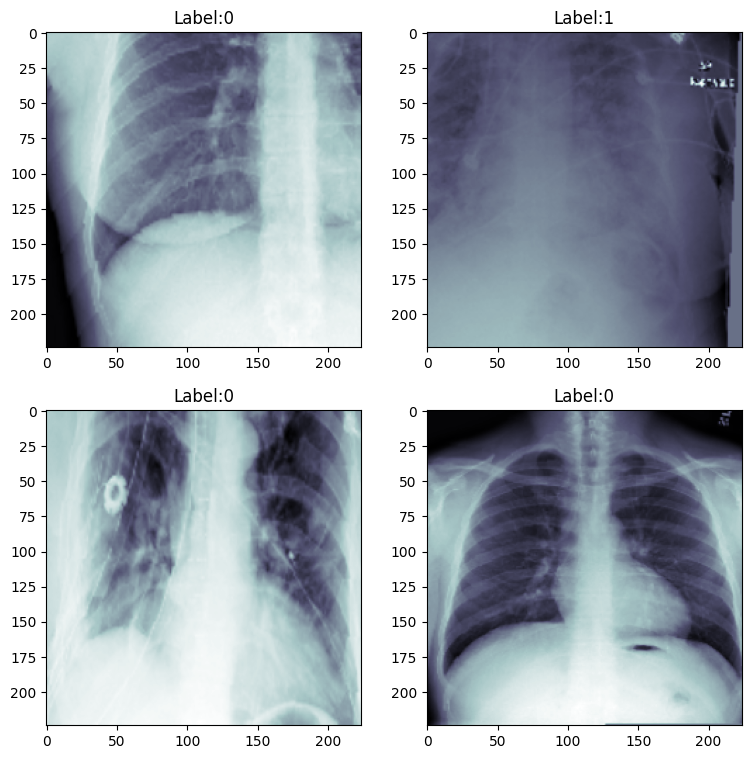

In [23]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 24000)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")


In [24]:
batch_size = 64
num_workers = 2

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 24000 train images and 2684 val images


In [25]:
np.unique(train_dataset.targets, return_counts=True), np.unique(val_dataset.targets, return_counts=True)

((array([0, 1]), array([18593,  5407])), (array([0, 1]), array([2079,  605])))

In [26]:
import torch
import torchvision
import torchmetrics
import pytorch_lightning as pl

class PneumoniaModel(pl.LightningModule):
    def __init__(self, weight=1):
        super().__init__()

        self.model = torchvision.models.resnet18()
        # change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))

        # simple accuracy computation
        self.train_acc = torchmetrics.Accuracy(task='binary')
        self.val_acc = torchmetrics.Accuracy(task='binary')

    def forward(self, data):
        pred = self.model(data)
        return pred

    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)[:, 0]  # Prediction: Make sure prediction and label have the same shape
        loss = self.loss_fn(pred, label)  # Compute the loss

        # Log loss and batch accuracy
        self.log("Train Loss", loss, on_step=True, on_epoch=True)
        self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()), on_step=True, on_epoch=True)
        return loss

    def on_train_epoch_end(self):
        # After one epoch, log the train accuracy and reset it for the next epoch
        self.log("Train Acc", self.train_acc.compute())
        self.train_acc.reset()  # Reset the metric for the next epoch

    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]  # Make sure prediction and label have the same shape

        loss = self.loss_fn(pred, label)

        # Log validation metrics
        self.log("Val Loss", loss, on_step=True, on_epoch=True)
        self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()), on_step=True, on_epoch=True)
        return loss

    def on_validation_epoch_end(self):
        # Log the validation accuracy and reset it for the next epoch
        self.log("Val Acc", self.val_acc.compute())
        self.val_acc.reset()  # Reset the metric for the next epoch

    def configure_optimizers(self):
        # Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]


In [27]:
model = PneumoniaModel()  # Instanciate the model

In [28]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Acc',
    save_top_k=10,
    mode='max')

In [29]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

gpus = 1  # Number of GPUs to use

# Updated Trainer initialization
trainer = pl.Trainer(
    accelerator='gpu',  # Use 'gpu' as the accelerator
    devices=gpus,  # Number of GPUs to use
    logger=TensorBoardLogger(save_dir="./logs"),  # Logger configuration
    log_every_n_steps=1,  # Logging frequency
    callbacks=[checkpoint_callback],  # Callback configuration
    max_epochs=20  # Maximum number of epochs
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [30]:
trainer.fit(model, train_loader, val_loader)



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ResNet            | 11.2 M | train
1 | loss_fn   | BCEWithLogitsLoss | 0      | train
2 | train_acc | BinaryAccuracy    | 0      | train
3 | val_acc   | BinaryAccuracy    | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Use strict=False, otherwise we would want to match the pos_weight which is not necessary
model = PneumoniaModel.load_from_checkpoint("/content/logs/lightning_logs/version_0/checkpoints/epoch=14-step=5625.ckpt")
model.eval()
model.to(device);

In [34]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()


  0%|          | 0/2684 [00:00<?, ?it/s]

In [37]:
from torchmetrics import Accuracy, Precision, Recall, ConfusionMatrix

# Initialize the metrics with the task argument
acc = Accuracy(task='binary')(preds, labels)
precision = Precision(task='binary')(preds, labels)
recall = Recall(task='binary')(preds, labels)

# Initialize ConfusionMatrix with task argument
cm = ConfusionMatrix(num_classes=2, task='binary')(preds, labels)  # For binary classification
cm_threshed = ConfusionMatrix(num_classes=2, threshold=0.25, task='binary')(preds, labels)



print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")
print(f"Confusion Matrix 2:\n {cm_threshed}")

Val Accuracy: 0.8457525968551636
Val Precision: 0.6720720529556274
Val Recall: 0.6165289282798767
Confusion Matrix:
 tensor([[1897,  182],
        [ 232,  373]])
Confusion Matrix 2:
 tensor([[1514,  565],
        [  67,  538]])


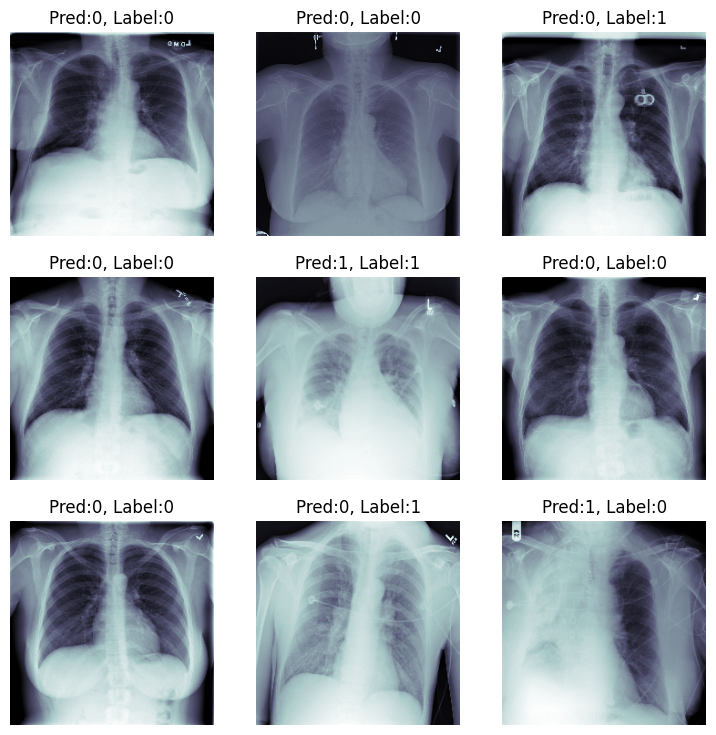

In [38]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        rnd_idx = np.random.randint(0, len(preds))
        axis[i][j].imshow(val_dataset[rnd_idx][0][0], cmap="bone")
        axis[i][j].set_title(f"Pred:{int(preds[rnd_idx] > 0.5)}, Label:{labels[rnd_idx]}")
        axis[i][j].axis("off")


In [39]:
%matplotlib inline
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

In [40]:
def load_file(path):
  return np.load(path).astype(np.float32)

In [41]:
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.49], [0.248]),
])

In [42]:
val_dataset = torchvision.datasets.DatasetFolder(
    root="/content/Processed/val",
    loader=load_file,
    extensions="npy",
    transform=val_transforms
)

In [43]:
temp_model = torchvision.models.resnet18()
temp_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [44]:
list(temp_model.children())[:-2]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [45]:
torch.nn.Sequential(*list(temp_model.children())[:-2])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [46]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.model = torchvision.models.resnet18()
        # Change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # Change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)

        # Extract the feature map
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])
    def forward(self, data):

        # Compute feature map
        feature_map = self.feature_map(data)
        # Use Adaptive Average Pooling as in the original model
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size=(1, 1))
        print(avg_pool_output.shape)
        # Flatten the output into a 512 element vector
        avg_pool_output_flattened = torch.flatten(avg_pool_output)
        print(avg_pool_output_flattened.shape)
        # Compute prediction
        pred = self.model.fc(avg_pool_output_flattened)
        return pred, feature_map



In [47]:
def cam(model, img):
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    features = features.reshape((512, 49))
    weight_params = list(model.model.fc.parameters())[0]
    weight = weight_params[0].detach()


    cam = torch.matmul(weight, features)
    cam_img = cam.reshape(7, 7).cpu()
    return cam_img, torch.sigmoid(pred)

In [50]:
# Use strict to prevent pytorch from loading weights for self.feature_map
model = PneumoniaModel.load_from_checkpoint("/content/logs/lightning_logs/version_0/checkpoints/epoch=7-step=3000.ckpt", strict=False)
model.eval();

In [51]:
def cam(model, img):
    """
    Compute class activation map according to cam algorithm
    """
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    b, c, h, w = features.shape

    # We reshape the 512x7x7 feature tensor into a 512x49 tensor in order to simplify the multiplication
    features = features.reshape((c, h*w))

    # Get only the weights, not the bias
    weight_params = list(model.model.fc.parameters())[0]

    # Remove gradient information from weight parameters to enable numpy conversion
    weight = weight_params[0].detach()
    print(weight.shape)
    # Compute multiplication between weight and features with the formula from above.
    # We use matmul because it directly multiplies each filter with the weights
    # and then computes the sum. This yields a vector of 49 (7x7 elements)
    cam = torch.matmul(weight, features)
    print(features.shape)

    ### The following loop performs the same operations in a less optimized way
    #cam = torch.zeros((7 * 7))
    #for i in range(len(cam)):
    #    cam[i] = torch.sum(weight*features[:,i])
    ##################################################################

    # Normalize and standardize the class activation map (Not always necessary, thus not shown in the lecture)
    cam = cam - torch.min(cam)
    cam_img = cam / torch.max(cam)
    # Reshape the class activation map to 512x7x7 and move the tensor back to CPU
    cam_img = cam_img.reshape(h, w).cpu()

    return cam_img, torch.sigmoid(pred)

def visualize(img, heatmap, pred):
    """
    Visualization function for class activation maps
    """
    img = img[0]
    # Resize the activation map of size 7x7 to the original image size (224x224)
    heatmap = transforms.functional.resize(heatmap.unsqueeze(0), (img.shape[0], img.shape[1]))[0]

    # Create a figure
    fig, axis = plt.subplots(1, 2)

    axis[0].imshow(img, cmap="bone")
    # Overlay the original image with the upscaled class activation map
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(heatmap, alpha=0.5, cmap="jet")
    plt.title(f"Pneumonia: {(pred > 0.5).item()}")

In [52]:
def visualize(img, cam, pred):
    img = img[0]
    cam = transforms.functional.resize(cam.unsqueeze(0), (224, 224))[0]

    fig, axis = plt.subplots(1, 2)
    axis[0].imshow(img, cmap="bone")
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(cam, alpha=0.5, cmap="jet")
    plt.title(pred)

In [54]:
# Assuming 'device' is already defined (e.g., device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
img = val_dataset[-6][0]  # Select a subject

# Move the image to the same device as the model
img = img.to(device)  # Ensure img is on the same device as model

# Now compute the Class activation map
activation_map, pred = cam(model, img)  # Compute the Class activation map given the subject


torch.Size([1, 512, 1, 1])
torch.Size([512])
torch.Size([512])
torch.Size([512, 49])


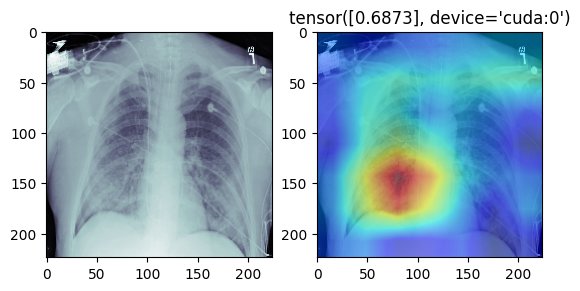

In [56]:
# Move img and activation_map to CPU before visualizing
img_cpu = img.cpu()  # Move img to CPU
activation_map_cpu = activation_map.cpu()  # Move activation_map to CPU

# Visualize CAM
visualize(img_cpu, activation_map_cpu, pred)  # Pass the CPU tensors to the visualize function
